In [1]:
import pandas as pd
from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()
import mplfinance as mpf
import numpy as np

In [2]:
start = '2020-01-01'
end = '2021-01-01'

In [3]:
data = web.get_data_yahoo('aapl', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [4]:
def macd_func(df, a=12, b=26, c=9):
    # MACD
    EMA_short = df['Close'].ewm(span=a, adjust=False, min_periods = a+1).mean()
    EMA_long = df['Close'].ewm(span=b, adjust=False, min_periods = b+1).mean()
    MACD = EMA_short - EMA_long
    signal = MACD.ewm(span=c, adjust=False, min_periods = c+1).mean()
    df['macd'] = MACD
    df['signal_line'] = signal
    df['histogram'] = df['macd'] - df['signal_line']
    # Find entry point
    df['shift_hist'] = df['histogram'].shift(1)
    df[(df['histogram'] > 0) & (df['shift_hist'] < 0)]
    df.loc[(df['histogram'] > 0) & (df['shift_hist'] < 0), 'action'] = 'buy'
    df.loc[(df['histogram'] < 0) & (df['shift_hist'] > 0), 'action'] = 'sell'
    df.loc[df['action'] == 'buy', 'marker_position'] = df['Low'] * 0.98
    df.loc[df['action'] == 'sell', 'marker_position'] = df['High'] * 1.02
    return df

In [5]:
apple_macd = macd_func(data)

In [6]:
apple_macd[apple_macd['action'] == 'buy']

,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position
Date,,,,,,,,,,,,
2020-03-26,61.630001,64.669998,61.590000,64.610001,63.815437,252087200,-3.879425,-3.898830,0.019405,-0.433973,buy,60.358200
2020-06-08,82.562500,83.400002,81.830002,83.364998,82.562660,95654400,2.398502,2.359570,0.038932,-0.036795,buy,80.193402
2020-07-08,94.180000,95.375000,94.089996,95.342499,94.424889,117092000,3.226994,3.109176,0.117817,-0.004730,buy,92.208196
2020-07-20,96.417503,98.500000,96.062500,98.357498,97.410866,90318000,3.351048,3.347707,0.003341,-0.026374,buy,94.141250
2020-07-31,102.885002,106.415001,100.824997,106.260002,105.237312,374336800,2.418195,2.275945,0.142250,-0.600409,buy,98.808497
2020-10-01,117.639999,117.720001,115.830002,116.790001,115.874504,116120400,-0.326452,-0.582223,0.255770,-0.018350,buy,113.513402
2020-11-06,118.320000,119.199997,116.129997,118.690002,117.962791,114457900,-0.170052,-0.423293,0.253241,-0.068492,buy,113.807397
2020-12-01,121.010002,123.470001,120.010002,122.720001,121.968094,127728200,0.765601,0.487151,0.278450,-0.075444,buy,117.609802


In [19]:
def macd_plot(df_plot):
    df = macd_func(df_plot)
    # For plot MACD
    mpf_macd = mpf.make_addplot(df['macd'], panel=1, color='blue', title='MACD')
    mpf_signal = mpf.make_addplot(df['signal_line'], panel=1, color='orange')
    
    colors = ['green' if value >= 0 else 'red' for value in df['histogram']]
    mpf_histogram = mpf.make_addplot(df['histogram'], type='bar', panel=1, color=colors)
    
    # For marker
    markers = ['^' if x == 'buy' else 'v' for x in df['action']]
    color_marker = ['green' if x == 'buy' else 'red' for x in df['action']]
    plot_signal = mpf.make_addplot(df['marker_position'], type='scatter', markersize=30, marker=markers, color=color_marker)
    
    plots = [mpf_macd, mpf_signal, mpf_histogram, plot_signal]
    
    return plots

In [20]:
a = macd_plot(data)

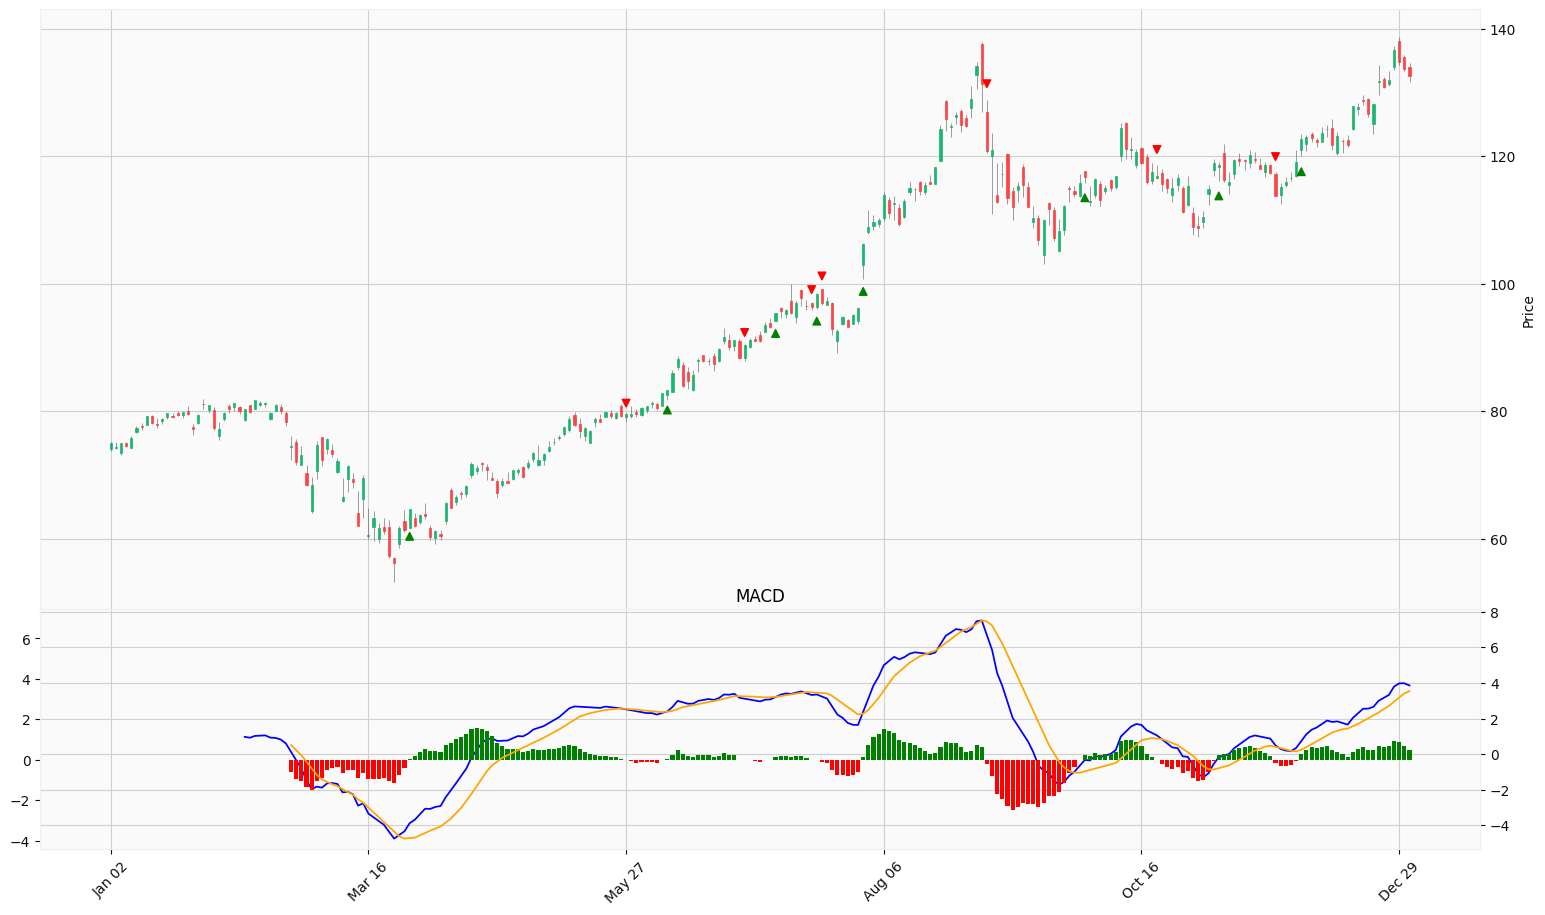

In [21]:
mpf.plot(data, type='candle', style='yahoo', addplot=a, figsize=(20, 12))